# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn"))

from data import isic_archive_load
from auc_metric import calculate_auc
from gradcam import display_gradcam, make_gradcam_heatmap, get_img_array
from fractal.perc import FractalImage

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
tf.get_logger().setLevel('ERROR')

### Model description

- Model architecture: MobileNet V2
- Fractal module used: with Percolation 
- Number of layers tuned: 1

### Load the ISIC Archive dataset

In [4]:
training_set, testing_set, validation_set = isic_archive_load()

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/data/isic_archive.py:20: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


### Model definition and callbacks

In [5]:
class LesionClassifier(tf.keras.Model):
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    
    def __init__(self, class_number):
        super(LesionClassifier, self).__init__()
        
        self.fractal_image = FractalImage()
        self.resize = tf.keras.layers.Resizing(
            width=self.TARGET_WIDTH,
            height=self.TARGET_HEIGHT
        )
        self.rescale = tf.keras.layers.Rescaling(scale=1./255)
        
        self.o_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.o_model.layers:
            if layer.name in ['block_16_project_BN']:
                layer.trainable = True
            else:
                layer.trainable = False   
        
        self.f_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.f_model.layers:
            if layer.name in ['block_16_project_BN']:
                layer.trainable = True
            else:
                layer.trainable = False  
        
        self.concatenate = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)
        
        f_outputs = self.fractal_image(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)
        
        outputs = self.concatenate([f_outputs, o_outputs])
        outputs = self.dense(outputs)
        
        return outputs

In [6]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [7]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

### Training

In [8]:
strategy = tf.distribute.MirroredStrategy()

In [9]:
with strategy.scope():
    model = LesionClassifier(class_number=len(training_set.class_indices))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/30
947/947 [==============================] - ETA: 0s - loss: 1.2498 - accuracy: 0.6653
Epoch 1: val_loss improved from inf to 1.34567, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6396s 7s/step - loss: 1.2498 - accuracy: 0.6653 - val_loss: 1.3457 - val_accuracy: 0.6660
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 1.2303 - accuracy: 0.6659
Epoch 2: val_loss improved from 1.34567 to 1.27301, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7841s 8s/step - loss: 1.2303 - accuracy: 0.6659 - val_loss: 1.2730 - val_accuracy: 0.6660
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 1.2178 - accuracy: 0.6659
Epoch 3: val_loss improved from 1.27301 to 1.20885, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7507s 8s/step - loss: 1.2178 - accuracy: 0.6659 - val_loss: 1.2088 - val_accuracy: 0.6660
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 1.2104 - accuracy: 0.6659
Epoch 4: val_loss did not improve from 1.20885
947/947 [==============================] - 7862s 8s/step - loss: 1.2104 - accuracy: 0.6659 - val_loss: 1.2354 - val_accuracy: 0.6660
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 1.2085 - accuracy: 0.6659
Epoch 5: val_loss improved from 1.20885 to 1.20612, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8098s 9s/step - loss: 1.2085 - accuracy: 0.6659 - val_loss: 1.2061 - val_accuracy: 0.6660
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 1.2028 - accuracy: 0.6659
Epoch 6: val_loss improved from 1.20612 to 1.19692, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8346s 9s/step - loss: 1.2028 - accuracy: 0.6659 - val_loss: 1.1969 - val_accuracy: 0.6660
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 1.2006 - accuracy: 0.6659
Epoch 7: val_loss improved from 1.19692 to 1.19492, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8724s 9s/step - loss: 1.2006 - accuracy: 0.6659 - val_loss: 1.1949 - val_accuracy: 0.6660
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 1.1979 - accuracy: 0.6659
Epoch 8: val_loss improved from 1.19492 to 1.19034, saving model to checkpoints/model.ckpt


947/947 [==============================] - 10291s 11s/step - loss: 1.1979 - accuracy: 0.6659 - val_loss: 1.1903 - val_accuracy: 0.6660
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 1.1949 - accuracy: 0.6659
Epoch 9: val_loss did not improve from 1.19034
947/947 [==============================] - 9997s 11s/step - loss: 1.1949 - accuracy: 0.6659 - val_loss: 1.1904 - val_accuracy: 0.6660
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 1.1935 - accuracy: 0.6659
Epoch 10: val_loss improved from 1.19034 to 1.18666, saving model to checkpoints/model.ckpt


947/947 [==============================] - 9536s 10s/step - loss: 1.1935 - accuracy: 0.6659 - val_loss: 1.1867 - val_accuracy: 0.6660
Epoch 11/30
947/947 [==============================] - ETA: 0s - loss: 1.1895 - accuracy: 0.6659
Epoch 11: val_loss improved from 1.18666 to 1.18187, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8587s 9s/step - loss: 1.1895 - accuracy: 0.6659 - val_loss: 1.1819 - val_accuracy: 0.6660
Epoch 12/30
947/947 [==============================] - ETA: 0s - loss: 1.1874 - accuracy: 0.6659
Epoch 12: val_loss improved from 1.18187 to 1.18134, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8140s 9s/step - loss: 1.1874 - accuracy: 0.6659 - val_loss: 1.1813 - val_accuracy: 0.6660
Epoch 13/30
947/947 [==============================] - ETA: 0s - loss: 1.1833 - accuracy: 0.6659
Epoch 13: val_loss improved from 1.18134 to 1.17309, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6950s 7s/step - loss: 1.1833 - accuracy: 0.6659 - val_loss: 1.1731 - val_accuracy: 0.6660
Epoch 14/30
947/947 [==============================] - ETA: 0s - loss: 1.1818 - accuracy: 0.6659
Epoch 14: val_loss improved from 1.17309 to 1.17191, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6022s 6s/step - loss: 1.1818 - accuracy: 0.6659 - val_loss: 1.1719 - val_accuracy: 0.6660
Epoch 15/30
947/947 [==============================] - ETA: 0s - loss: 1.1801 - accuracy: 0.6660
Epoch 15: val_loss did not improve from 1.17191
947/947 [==============================] - 5626s 6s/step - loss: 1.1801 - accuracy: 0.6660 - val_loss: 1.1729 - val_accuracy: 0.6661
Epoch 16/30
947/947 [==============================] - ETA: 0s - loss: 1.1775 - accuracy: 0.6661
Epoch 16: val_loss did not improve from 1.17191
947/947 [==============================] - 6363s 7s/step - loss: 1.1775 - accuracy: 0.6661 - val_loss: 1.1753 - val_accuracy: 0.6660
Epoch 17/30
947/947 [==============================] - ETA: 0s - loss: 1.1763 - accuracy: 0.6661
Epoch 17: val_loss did not improve from 1.17191
947/947 [==============================] - 9279s 10s/step - loss: 1.1763 - accuracy: 0.6661 - val_loss: 1.1754 - val_accuracy: 0.6682
Epoch 18/30
947/947 [===========

### Testing

In [11]:
model.load_weights(checkpoint_path)

In [12]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [13]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 510s 3s/step


In [14]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [15]:
auc_metric

{'actinic keratosis': 0.6872497226477892,
 'basal cell carcinoma': 0.6366804513555653,
 'dermatofibroma': 0.5405834528933524,
 'melanoma': 0.6335613113172018,
 'nevus': 0.6546324562490959,
 'pigmented benign keratosis': 0.569792431286192,
 'seborrheic keratosis': 0.6532568534738908,
 'solar lentigo': 0.6099767253759428,
 'squamous cell carcinoma': 0.6090213485521031,
 'vascular lesion': 0.43937221679157157}

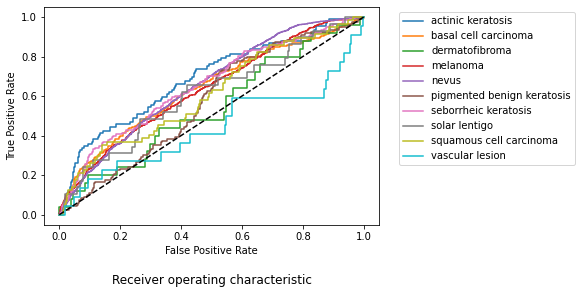

In [16]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

### GradCam

In [17]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

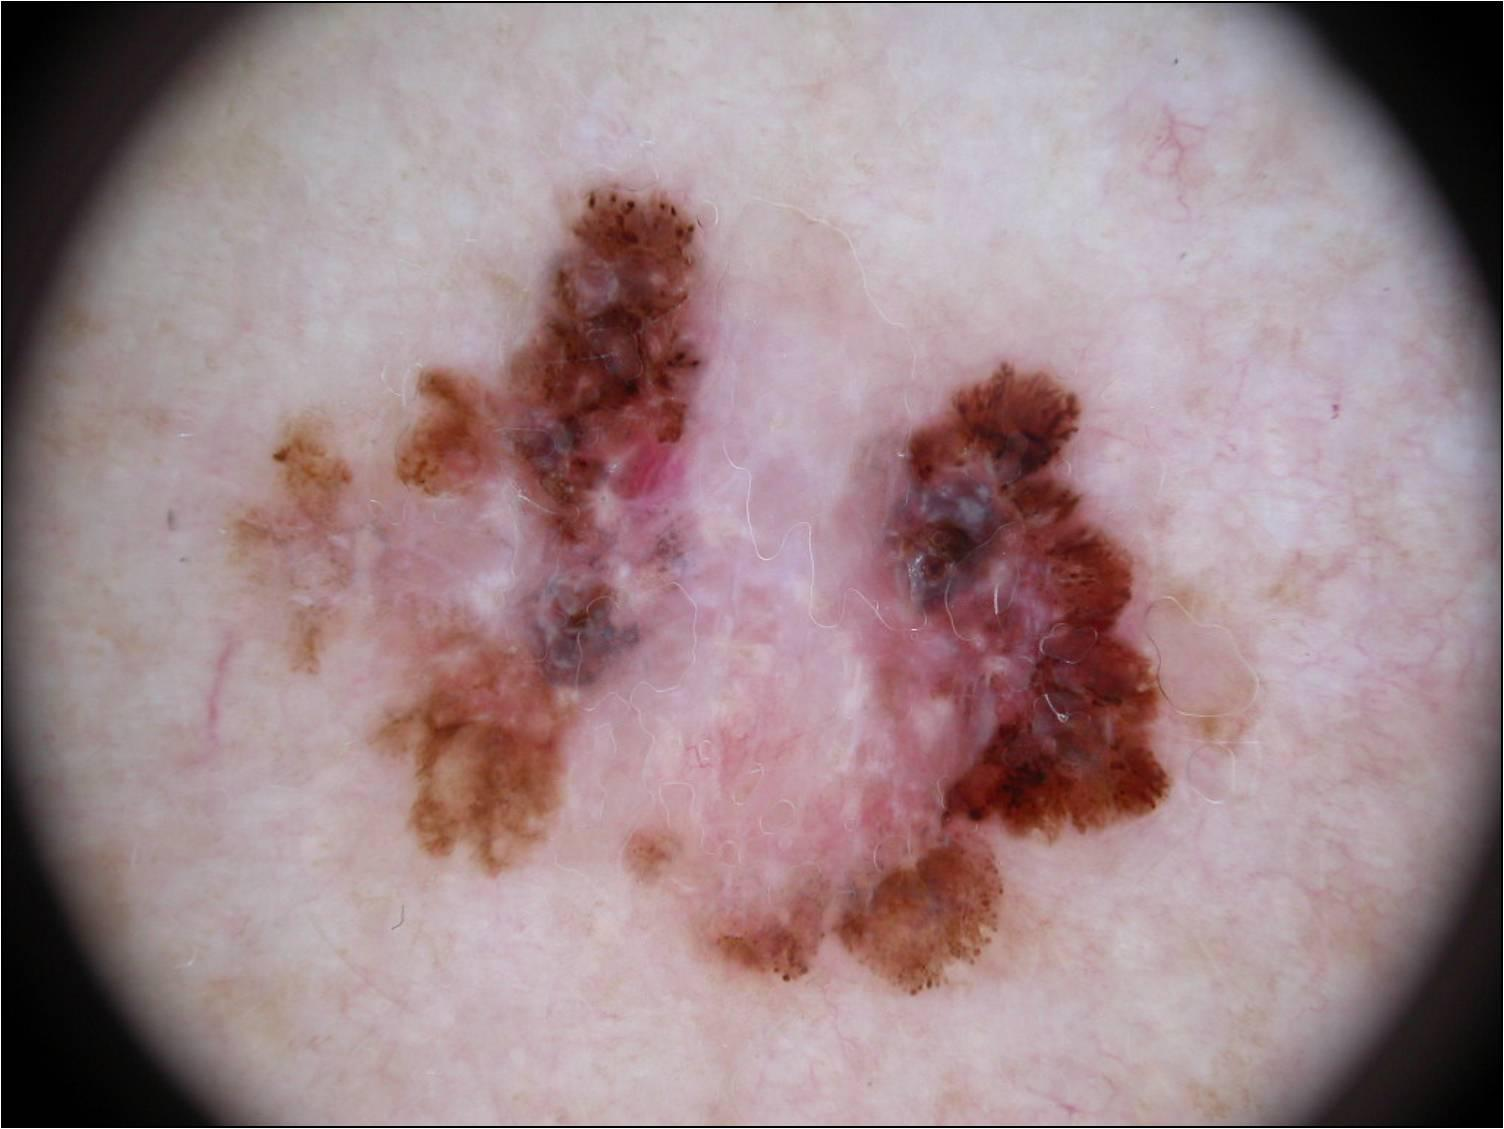

In [18]:
display(Image(melanoma_im_path, width=600))

In [19]:
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(get_img_array(melanoma_im_path, size=(299, 299)))

In [20]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'block_16_project_BN')

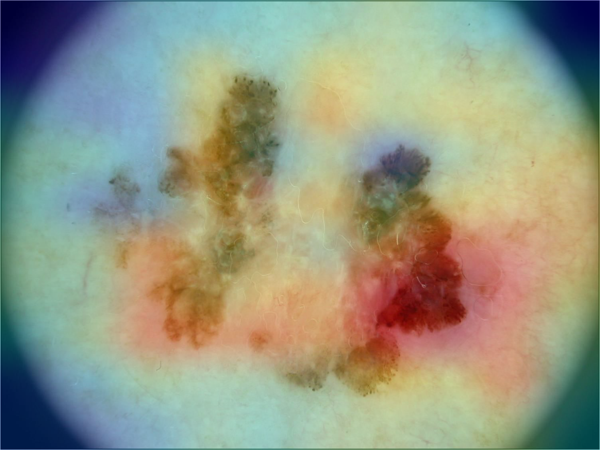

In [21]:
display_gradcam(melanoma_im_path, heatmap)